# About this notebook
- PyTorch tf_efficientnet_b7_ns starter code
- StratifiedKFold 5 folds
- Inference notebook is [here](https://www.kaggle.com/yasufuminakama/g2net-efficientnet-b7-baseline-inference)
- Spectrogram generation code
    - https://www.kaggle.com/yasufuminakama/g2net-n-mels-128-train-images is generated by https://www.kaggle.com/yasufuminakama/g2net-spectrogram-generation-train
    - https://www.kaggle.com/yasufuminakama/g2net-n-mels-128-test-images is generated by https://www.kaggle.com/yasufuminakama/g2net-spectrogram-generation-test
- version 2: melspectrogram approach using above dataset
- version 3: nnAudio Q-transform approach
    - Here is nnAudio Constant Q-transform Demonstration  
        - https://www.kaggle.com/atamazian/nnaudio-constant-q-transform-demonstration
        - https://www.kaggle.com/c/g2net-gravitational-wave-detection/discussion/250621
    - Thanks for sharing @atamazian  
- version 4: tf_efficientnet_b0_ns -> tf_efficientnet_b7_ns
- version 6: W&B and Grad-CAM
    - Pytorch W&B Usage Examples from https://docs.wandb.ai/guides/integrations/pytorch

If this notebook is helpful, feel free to upvote :)

# Data Loading

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('input/training_labels.csv')
test = pd.read_csv('input/sample_submission.csv')

def get_train_file_path(image_id):
    return "input/train/{}/{}/{}/{}.npy".format(
        image_id[0], image_id[1], image_id[2], image_id)

def get_test_file_path(image_id):
    return "input/test/{}/{}/{}/{}.npy".format(
        image_id[0], image_id[1], image_id[2], image_id)

train['file_path'] = train['id'].apply(get_train_file_path)
test['file_path'] = test['id'].apply(get_test_file_path)

display(train.head())
display(test.head())

,id,target,file_path
0,00000e74ad,1,input/train/0/0/0/00000e74ad.npy
1,00001f4945,0,input/train/0/0/0/00001f4945.npy
2,0000661522,0,input/train/0/0/0/0000661522.npy
3,00007a006a,0,input/train/0/0/0/00007a006a.npy
4,0000a38978,1,input/train/0/0/0/0000a38978.npy


,id,target,file_path
0,00005bced6,0.5,input/test/0/0/0/00005bced6.npy
1,0000806717,0.5,input/test/0/0/0/0000806717.npy
2,0000ef4fe1,0.5,input/test/0/0/0/0000ef4fe1.npy
3,00020de251,0.5,input/test/0/0/0/00020de251.npy
4,00024887b5,0.5,input/test/0/0/0/00024887b5.npy


# Quick EDA

CQT kernels created, time used = 0.0125 seconds


/opt/conda/lib/python3.7/site-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)


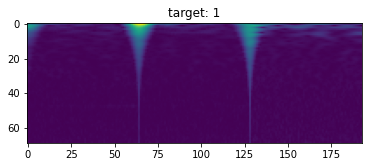

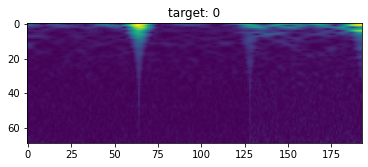

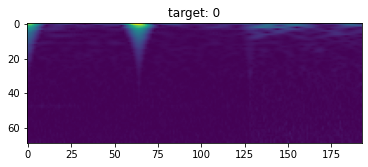

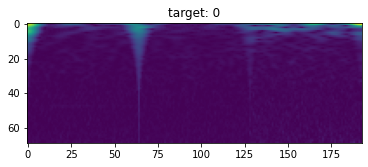

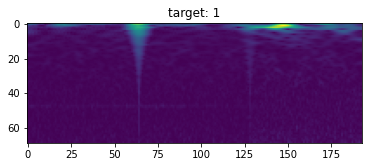

In [3]:
import torch
from nnAudio.Spectrogram import CQT1992v2

def apply_qtransform(waves, transform=CQT1992v2(sr=2048, fmin=20, fmax=1024, hop_length=64)):
    waves = np.hstack(waves)
    waves = waves / np.max(waves)
    waves = torch.from_numpy(waves).float()
    image = transform(waves)
    return image

for i in range(5):
    waves = np.load(train.loc[i, 'file_path'])
    image = apply_qtransform(waves)
    target = train.loc[i, 'target']
    plt.imshow(image[0])
    plt.title(f"target: {target}")
    plt.show()

<AxesSubplot:>

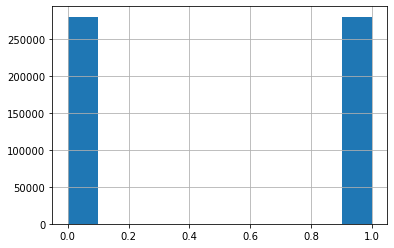

In [4]:
train['target'].hist()

# Directory settings

In [5]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# CFG

In [6]:
# ====================================================
# CFG
# ====================================================
class CFG:
    apex=False
    debug=False
    print_freq=100
    num_workers=4
    model_name='tf_efficientnetv2_l_in21k'
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs=10
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    T_max=10 # CosineAnnealingLR
    #T_0=3 # CosineAnnealingWarmRestarts
    lr=1e-4
    min_lr=1e-6
    batch_size=48
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    qtransform_params={"sr": 2048, "fmin": 20, "fmax": 1024, "hop_length": 32, "bins_per_octave": 8}
    seed=42
    target_size=1
    target_col='target'
    n_fold=5
    trn_fold=[0, 1, 2, 3, 4]
    train=True
    grad_cam=True
    mix_up=False
    cut_mix=False
    sam=True
    multisample_dropout=True
    
    
    
if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=10000, random_state=CFG.seed).reset_index(drop=True)

# Library

In [7]:
# ====================================================
# Library
# ====================================================
import sys
sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')

import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM

import timm
from adamp import AdamP
from torch.cuda.amp import autocast, GradScaler

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
import wandb
wandb.login(key='ad185fc040cf022e94161aaabaa8caec07cbb174')

def class2dict(f):
    return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

run = wandb.init(project="G2Net-Public-experiments", 
                 name="cuelab",
                 config=class2dict(CFG),
                 group=CFG.model_name,
                 job_type="train")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: cuelab (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/jupyter/.netrc
wandb: wandb version 0.12.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


# Utils

In [9]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = roc_auc_score(y_true, y_pred)
    return score


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

# CV split

In [10]:
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train[CFG.target_col])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby(['fold', 'target']).size())

fold  target
0     0         56014
      1         55986
1     0         56014
      1         55986
2     0         56014
      1         55986
3     0         56014
      1         55986
4     0         56014
      1         55986
dtype: int64

# Dataset

In [11]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.labels = df[CFG.target_col].values
        self.wave_transform = CQT1992v2(**CFG.qtransform_params)
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def apply_qtransform(self, waves, transform):
        waves = np.hstack(waves)
        waves = waves / np.max(waves)
        waves = torch.from_numpy(waves).float()
        image = transform(waves)
        return image

    def __getitem__(self, idx):
        file_path = self.file_names[idx]
        waves = np.load(file_path)
        image = self.apply_qtransform(waves, self.wave_transform)
        image = image.squeeze().numpy()
        if self.transform:
            image = self.transform(image=image)['image']
        label = torch.tensor(self.labels[idx]).float()
        return image, label

In [12]:
class GradCAMDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.image_ids = df['id'].values
        self.file_names = df['file_path'].values
        self.labels = df[CFG.target_col].values
        self.wave_transform = CQT1992v2(**CFG.qtransform_params)
        self.transform = get_transforms(data='valid')
        
    def __len__(self):
        return len(self.df)
    
    def apply_qtransform(self, waves, transform):
        waves = np.hstack(waves)
        waves = waves / np.max(waves)
        waves = torch.from_numpy(waves).float()
        image = transform(waves)
        return image

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        file_path = self.file_names[idx]
        waves = np.load(file_path)
        image = self.apply_qtransform(waves, self.wave_transform)
        image = image.squeeze().numpy()
        vis_image = image.copy()
        if self.transform:
            image = self.transform(image=image)['image']
        label = torch.tensor(self.labels[idx]).float()
        return image_id, image, vis_image, label

# Transforms

In [13]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            A.HorizontalFlip(p=0.5),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            ToTensorV2(),
        ])

In [14]:
def mixup_data(x, y, alpha=0.5, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [15]:
def rand_bbox(W, H, lam):
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    cx = np.random.randint(cut_w // 2, W - cut_w // 2)
    cy = np.random.randint(cut_h // 2, H - cut_h // 2)

    bbx1 = cx - cut_w // 2
    bby1 = cy - cut_h // 2
    bbx2 = cx + cut_w // 2
    bby2 = cy + cut_h // 2

    return bbx1, bby1, bbx2, bby2

def cutmix(x, y, alpha=0.5):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size()[1], x.size()[2], lam)
    x[:, bbx1:bbx2, bby1:bby2] = x[index, bbx1:bbx2, bby1:bby2]
    y_a, y_b = y, y[index]
    return x, y_a, y_b, lam

def cutmix_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

CQT kernels created, time used = 0.0135 seconds


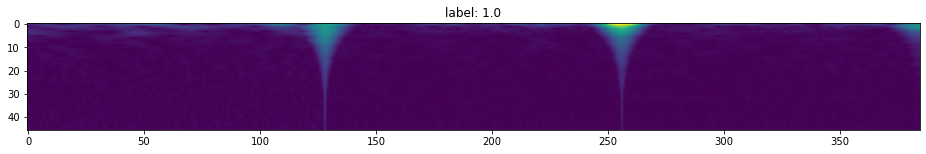

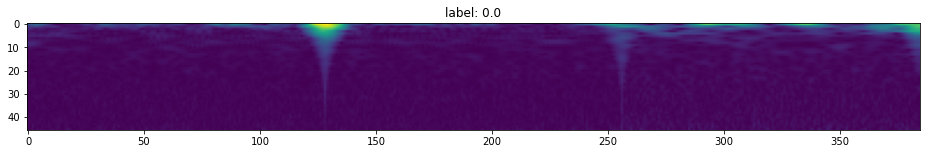

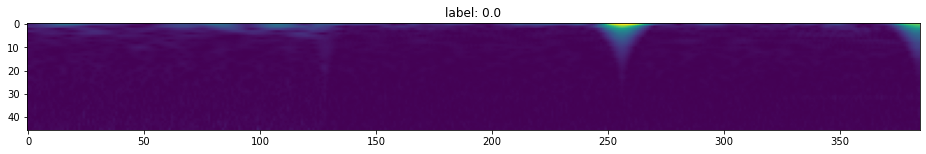

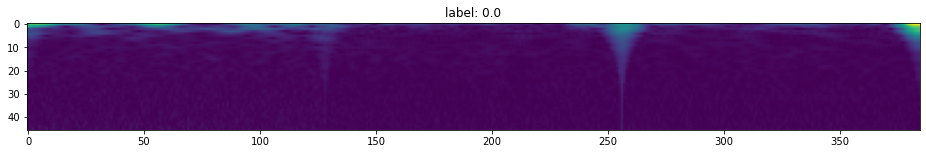

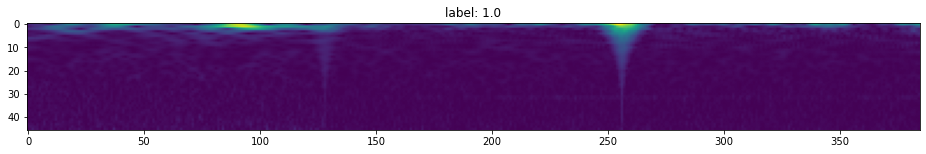

In [16]:
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

for i in range(5):
    plt.figure(figsize=(16,12))
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show() 

# MODEL

In [17]:
class GAP(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return F.adaptive_avg_pool2d(x, (1,1)).squeeze()

In [18]:
# ====================================================
# MODEL
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, pretrained=False):
        super().__init__()
        self.cfg = cfg
        self.model = timm.create_model(self.cfg.model_name, pretrained=pretrained, in_chans=1)
        if  "eff" in self.cfg.model_name:
            self.n_features = self.model.classifier.in_features
            #self.model.classifier = nn.Linear(self.n_features, self.cfg.target_size)
        elif "mixer" in self.cfg.model_name:
            self.n_features = self.model.head.in_features
            self.model.head = nn.Linear(self.n_features, self.cfg.target_size)
        elif "resnest" in self.cfg.model_name:
            self.n_features = self.model.fc.in_features
            self.model.fc = nn.Linear(self.n_features, self.cfg.target_size)
        elif "nfnet" in self.cfg.model_name:
            self.n_features = self.model.head.fc.in_features
            self.model.head.fc = nn.Linear(self.n_features, self.cfg.target_size)
        else:
            self.n_features = self.model.head.in_features
            self.model.head = nn.Linear(self.n_features, self.cfg.target_size)
        self.dropout = nn.Dropout(0.3)
        self.global_pool = GAP()
        self.flatten = nn.Flatten()
        self.l0 = nn.Linear(self.n_features, self.cfg.target_size)
        
    def forward(self, x):
        if self.cfg.multisample_dropout:
            features = self.model.forward_features(x)
            x = self.global_pool(features)
            x = self.flatten(x)
            x = torch.mean(
                torch.stack(
                    [self.l0(self.dropout(x)) for _ in range(5)],
                    dim=0,
                ),
                dim=0,
            )
        else:
            x = self.model(x)
        return x

# Helper functions

In [19]:
class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, **kwargs)
        super(SAM, self).__init__(params, defaults)
        
        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                e_w = p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"
                self.state[p]["e_w"] = e_w

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.sub_(self.state[p]["e_w"])  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        p.grad.norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

In [20]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    if CFG.apex:
        scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)
        batch_size = labels.size(0)
        
        if CFG.mix_up:
            inputs1, targets_a, targets_b, lam = mixup_data(images, labels.view(-1, 1), use_cuda=True)

            inputs1 = inputs1.to(device, dtype=torch.float)
            targets_a = targets_a.to(device, dtype=torch.float)
            targets_b = targets_b.to(device, dtype=torch.float)
            
            if CFG.apex:
                with autocast():
                    outputs = model(inputs1)
                    loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            else:
                outputs = model(inputs1)
                loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        
        elif CFG.cut_mix:
            inputs1, targets_a, targets_b, lam = cutmix(images, labels.view(-1, 1))

            inputs1 = inputs1.to(device, dtype=torch.float)
            targets_a = targets_a.to(device, dtype=torch.float)
            targets_b = targets_b.to(device, dtype=torch.float)
            
            if CFG.apex:
                with autocast():
                    outputs = model(inputs1)
                    loss = cutmix_criterion(criterion, outputs, targets_a, targets_b, lam)
            else:
                outputs = model(inputs1)
                loss = cutmix_criterion(criterion, outputs, targets_a, targets_b, lam)
        else:
            if CFG.apex:
                with autocast():
                    y_preds = model(images)
                    loss = criterion(y_preds.view(-1), labels)
            else:
                y_preds = model(images)
                loss = criterion(y_preds.view(-1), labels)
                
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            scaler.scale(loss).backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            if CFG.apex:
                scaler.step(optimizer)
                scaler.update()
            else:
                if CFG.sam:
                    optimizer.first_step(zero_grad=True)
                    
                    if CFG.mix_up:
                        mixup_criterion(criterion, model(inputs1), targets_a, targets_b, lam).backward()
                    elif CFG.cut_mix:
                        cutmix_criterion(criterion, model(inputs1), targets_a, targets_b, lam).backward()
                    else:
                        criterion(model(images).view(-1), labels).backward()
                    
                    optimizer.second_step(zero_grad=True)
                else:
                    optimizer.step()
                    optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            #mlflow.log_metric('lr', scheduler.get_lr()[0], step=epoch)
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   lr=scheduler.get_lr()[0],
                   ))
        wandb.log({f"[fold{fold}] loss": losses.val,
                   f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds.view(-1), labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

In [21]:
def get_grad_cam(model, device, x_tensor, img, label, plot=False):
    
    result = {"vis": None, "img": None, "prob": None, "label": None}
    
    # model prob
    with torch.no_grad():
        prob = model(x_tensor.unsqueeze(0).to(device))
    prob = np.concatenate(prob.sigmoid().to('cpu').numpy())[0]
    
    # grad-cam
    target_layer = model.model.conv_head
    cam = GradCAM(model=model, target_layer=target_layer, use_cuda=True)
    output = cam(input_tensor=x_tensor.unsqueeze(0))
    try:
        vis = show_cam_on_image(x_tensor.numpy().transpose((1, 2, 0)), output[0])
    except:
        return result

    # plot result
    if plot:
        fig, axes = plt.subplots(figsize=(16, 12), ncols=2)
        axes[0].imshow(vis)
        axes[0].set_title(f"prob={prob:.4f}")
        axes[1].imshow(img)
        axes[1].set_title(f"target={label}")
        plt.show()
        
    result = {"vis": vis, "img": img, "prob": prob, "label": label}

    return result

# Train loop

In [22]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_col].values

    train_dataset = TrainDataset(train_folds, transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data='train'))

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size * 2, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, pretrained=True)
    model.to(device)
    if CFG.sam:
        base_optimizer = AdamP
        optimizer = SAM(model.parameters(), base_optimizer, lr=CFG.lr, weight_decay=CFG.weight_decay)
    else:
        optimizer = AdamP(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
        
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss()

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        wandb.log({f"[fold{fold}] epoch": epoch+1, 
                   f"[fold{fold}] avg_train_loss": avg_loss, 
                   f"[fold{fold}] avg_val_loss": avg_val_loss,
                   f"[fold{fold}] score": score})
        
        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_score.pth')
        
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_loss.pth')
    
    valid_folds['preds'] = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_score.pth', 
                                      map_location=torch.device('cpu'))['preds']

    return valid_folds

In [23]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train 
    """

    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
    
    if CFG.grad_cam:
        N = 5
        wandb_table = wandb.Table(columns=["id", "target", "prob", "image", "grad_cam_image"])
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                # load model
                model = CustomModel(CFG, pretrained=False)
                state = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_loss.pth', 
                                   map_location=torch.device('cpu'))['model']
                model.load_state_dict(state)
                model.to(device)
                model.eval()
                # load oof
                oof = pd.read_csv(OUTPUT_DIR+'oof_df.csv')
                oof = oof[oof['fold'] == fold].reset_index(drop=True)
                # grad-cam (oof ascending=False)
                count = 0
                oof = oof.sort_values('preds', ascending=False)
                valid_dataset = GradCAMDataset(oof)
                for i in range(len(valid_dataset)):
                    image_id, x_tensor, img, label = valid_dataset[i]
                    result = get_grad_cam(model, device, x_tensor, img, label, plot=True)
                    if result["vis"] is not None:
                        count += 1
                        wandb_table.add_data(image_id, 
                                             result["label"], 
                                             result["prob"], 
                                             wandb.Image(result["img"]), 
                                             wandb.Image(result["vis"]))
                    if count >= N:
                        break
                # grad-cam (oof ascending=True)
                count = 0
                oof = oof.sort_values('preds', ascending=True)
                valid_dataset = GradCAMDataset(oof)
                for i in range(len(valid_dataset)):
                    image_id, x_tensor, img, label = valid_dataset[i]
                    result = get_grad_cam(model, device, x_tensor, img, label, plot=True)
                    if result["vis"] is not None:
                        count += 1
                        wandb_table.add_data(image_id, 
                                             result["label"], 
                                             result["prob"], 
                                             wandb.Image(result["img"]), 
                                             wandb.Image(result["vis"]))
                    if count >= N:
                        break
        wandb.log({'grad_cam': wandb_table})
    
    wandb.finish()

In [ ]:
if __name__ == '__main__':
    main()

========== fold: 0 training ==========


CQT kernels created, time used = 0.0059 seconds
CQT kernels created, time used = 0.0055 seconds
Epoch: [1][0/9333] Data 0.809 (0.809) Elapsed 0m 2s (remain 452m 29s) Loss: 0.7138(0.7138) Grad: 5.7107  LR: 0.000100  
Epoch: [1][100/9333] Data 0.000 (0.009) Elapsed 1m 52s (remain 171m 43s) Loss: 0.5251(0.6244) Grad: 1.2578  LR: 0.000100  
Epoch: [1][200/9333] Data 0.001 (0.005) Elapsed 3m 41s (remain 167m 52s) Loss: 0.5067(0.5842) Grad: 0.6796  LR: 0.000100  
Epoch: [1][300/9333] Data 0.001 (0.003) Elapsed 5m 30s (remain 165m 11s) Loss: 0.5302(0.5590) Grad: 0.7270  LR: 0.000100  
Epoch: [1][400/9333] Data 0.001 (0.003) Elapsed 7m 18s (remain 162m 46s) Loss: 0.5839(0.5458) Grad: 0.9314  LR: 0.000100  
Epoch: [1][500/9333] Data 0.000 (0.002) Elapsed 9m 9s (remain 161m 34s) Loss: 0.5366(0.5360) Grad: 0.4901  LR: 0.000100  
Epoch: [1][600/9333] Data 0.001 (0.002) Elapsed 11m 4s (remain 160m 51s) Loss: 0.4849(0.5288) Grad: 0.5905  LR: 0.000100  
Epoch: [1][700/9333] Data 0.001 (0.002) Elapsed